# Issues: 
**selector_args**

Note that
- PassiveLearning takes input df_Candidate
- GSxFunction takes input df1 and df2
- GSyFunction takes input df1 and df2 and Model
- GSxFunction takes input df1 and df2 and Model

In order to make the overall function RunLearningProcedure dynamic, I inserted selector_args for the different variable inputs for the SelectorType.

However, selector_args does not change with each iteration. As such, df_2/df_Candidate in each selector_args remains the same.

Instead, we can change it manually by adding 

        selector_args['df_Candidate'] = df_Candidate                   # NOTE: THIS IS NOT DYNAMIC 
        model_args['df_Train'] = df_Train                              # NOTE: THIS IS NOT DYNAMIC 

However, this is not dynamic as some SelectorType functions do not have df1/df_Train.

The issue with is similar model_args.

# Import Packages

In [1]:
import numpy as np
import math as math
import pandas as pd
import random as random
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist

# Import Functions

In [2]:
import importlib.util
import os

def source_directory(directory_path):
    for filename in os.listdir(directory_path):
        if filename.endswith(".py"):
            # Define the module name and path
            module_name = filename[:-3]  # Remove the .py extension
            module_path = os.path.join(directory_path, filename)
            
            # Dynamically load the module
            spec = importlib.util.spec_from_file_location(module_name, module_path)
            module = importlib.util.module_from_spec(spec)
            spec.loader.exec_module(module)
            
            # Inject all functions and variables into the global namespace
            globals().update({name: getattr(module, name) for name in dir(module) if not name.startswith("__")})

# Example usage
source_directory("../functions")


In [3]:
source_directory("/Users/simondn/Documents/RashomonActiveLearning/Python/functions/Main")
source_directory("/Users/simondn/Documents/RashomonActiveLearning/Python/functions/Prediction")
source_directory("/Users/simondn/Documents/RashomonActiveLearning/Python/functions/Selector")

## Input 

In [4]:
# ### Input ###
# N= 1000
# K = 1
# TestProportion = 0.2
# Seed = 3
# CandidateProportion = 0.8

# ### Set Up ###
# random.seed(Seed)
# np.random.seed(Seed)
# ErrorVec = []
# SelectedObservationHistory = []

# ### Generate Data ###
# df = DataGeneratingProcess(N,K)
# df_Train, df_Test, df_Candidate = TrainTestCandidateSplit(df, TestProportion, CandidateProportion)

In [5]:
def RunLearningProcedure(df_Train, df_Test, df_Candidate, 
                         SelectorType, selector_args,
                         ModelType, model_args):

    ### Set Up ###
    ErrorVec = []
    SelectedObservationHistory = []

    ### Algorithm
    for i in range(0, len(df_Candidate)):

        ### Prediction Model ###
        Model = ModelType(**model_args)
        if "Model" in selector_args.keys(): selector_args['Model'] = Model            # NOTE: THIS IS NOT DYNAMIC

        CurrentError = TestErrorFunction(Model, df_Test)
        ErrorVec.append(CurrentError)

        ### Sampling Procedure ###
        QueryObservationIndex = SelectorType(**selector_args)
        QueryObservation = df_Candidate.loc[[QueryObservationIndex]] # or should this be iloc
        SelectedObservationHistory.append(QueryObservationIndex)

        # print("Iteration: ", i, "| QueryIndex: ", QueryObservationIndex, "| Inclusion: ", QueryObservationIndex in df_Candidate.index)
        # print(df_Train)
        # print(df_Candidate)
        # print("---")
        
        ### Update Train and Candidate Sets ###
        df_Train = pd.concat([df_Train, QueryObservation])
        df_Candidate = df_Candidate.drop(QueryObservationIndex)

        ### Update selector_args and model_args ###                                     # NOTE: THIS IS NOT DYNAMIC
        if "df_Train" in model_args.keys(): model_args['df_Train'] = df_Train
        if "df_Train" in selector_args.keys(): selector_args['df_Train'] = df_Train
        if "df_Candidate" in selector_args.keys(): selector_args['df_Candidate'] = df_Candidate            

    return ErrorVec, SelectedObservationHistory

# Simulation

## Set Up

In [12]:
### Input ###
SimulationN = 100
N= 1000
K = 3
TestProportion = 0.2
CandidateProportion = 0.8
SimulationErrorResultsPassive = []
SimulationErrorResultsGSx = []
SimulationErrorResultsGSy_Test = []
SimulationErrorResultsGSy = []
SimulationErrorResultsiGS = []
SimulationErrorResultsiGS_Test = []

## Simulation

In [ ]:
for seed in range(0,SimulationN):

    print("Simulation iter: ", seed)

    ### Set Seed ###
    random.seed(seed)
    np.random.seed(seed)

    ### Set Up ###
    ErrorVec = []
    SelectedObservationHistory = []

    ### Generate Data ###
    df = DataGeneratingProcess(N,K)
    df_Train, df_Test, df_Candidate = TrainTestCandidateSplit(df, TestProportion, CandidateProportion)

    ### Learning Algorithm ###

    ## Passive ##
    ErrorVecPassive, SelectedObservationHistoryPassive = RunLearningProcedure(df_Train = df_Train, 
                     df_Test = df_Test, 
                     df_Candidate = df_Candidate, 
                     SelectorType = PassiveLearning, 
                     selector_args = {'df_Candidate' : df_Candidate},
                     ModelType = LinearRegressionFunction, 
                     model_args = {'df_Train' : df_Train}
                     )
    
    ## GSx ##
    ErrorVecGSx, SelectedObservationHistoryGSx = RunLearningProcedure(df_Train = df_Train, 
                     df_Test = df_Test, 
                     df_Candidate = df_Candidate, 
                     SelectorType = GSxFunction, 
                     selector_args = {'df_Train' : df_Train,
                                      'df_Candidate' : df_Candidate,
                                      'distance' : 'euclidean'},
                     ModelType = LinearRegressionFunction, 
                     model_args = {'df_Train' : df_Train}
                     )
    
    ## GSy - Training ##
    ErrorVecGSy, SelectedObservationHistoryGSy = RunLearningProcedure(df_Train = df_Train, 
                     df_Test = df_Test, 
                     df_Candidate = df_Candidate, 
                     SelectorType = GSyFunction, 
                     selector_args = {'df_Train' : df_Train,                  #  NOTE: or should this be df_Test
                                      'df_Candidate' : df_Candidate,
                                      'Model': None,
                                      'distance' : 'euclidean'},
                     ModelType = LinearRegressionFunction, 
                     model_args = {'df_Train' : df_Train}
                     )
    
    ## GSy - Test ##
    ErrorVecGSy_Test, SelectedObservationHistoryGSy_Test = RunLearningProcedure(df_Train = df_Train, 
                     df_Test = df_Test, 
                     df_Candidate = df_Candidate, 
                     SelectorType = GSyFunction, 
                     selector_args = {'df_Train' : df_Test,                  #  NOTE: or should this be df_Test
                                      'df_Candidate' : df_Candidate,
                                      'Model': None,
                                      'distance' : 'euclidean'},
                     ModelType = LinearRegressionFunction, 
                     model_args = {'df_Train' : df_Train}
                     )
    
    ## iGS ##
    ErrorVeciGS, SelectedObservationHistoryiGS = RunLearningProcedure(df_Train = df_Train, 
                     df_Test = df_Test, 
                     df_Candidate = df_Candidate, 
                     SelectorType = iGSFunction, 
                     selector_args = {'df_Train' : df_Train,                  #  NOTE: or should this be df_Test
                                      'df_Candidate' : df_Candidate,
                                      'Model': None,
                                      'distance' : 'euclidean'},
                     ModelType = LinearRegressionFunction, 
                     model_args = {'df_Train' : df_Train}
                     )
    
    ## iGS - Test ##
    ErrorVeciGS_Test, SelectedObservationHistoryiGS_Test = RunLearningProcedure(df_Train = df_Train, 
                     df_Test = df_Test, 
                     df_Candidate = df_Candidate, 
                     SelectorType = iGSFunction, 
                     selector_args = {'df_Train' : df_Test,                  #  NOTE: or should this be df_Test
                                      'df_Candidate' : df_Candidate,
                                      'Model': None,
                                      'distance' : 'euclidean'},
                     ModelType = LinearRegressionFunction, 
                     model_args = {'df_Train' : df_Train}
                     )
    
    ### Save ###
    SimulationErrorResultsPassive.append(ErrorVecPassive)
    SimulationErrorResultsGSx.append(ErrorVecGSx)
    SimulationErrorResultsGSy.append(ErrorVecGSy)
    SimulationErrorResultsGSy_Test.append(ErrorVecGSy_Test)
    SimulationErrorResultsiGS.append(ErrorVeciGS)
    SimulationErrorResultsiGS_Test.append(ErrorVeciGS_Test)


Simulation iter:  0
Simulation iter:  1
Simulation iter:  2
Simulation iter:  3
Simulation iter:  4
Simulation iter:  5
Simulation iter:  6
Simulation iter:  7
Simulation iter:  8
Simulation iter:  9
Simulation iter:  10
Simulation iter:  11
Simulation iter:  12
Simulation iter:  13
Simulation iter:  14
Simulation iter:  15
Simulation iter:  16
Simulation iter:  17
Simulation iter:  18
Simulation iter:  19
Simulation iter:  20
Simulation iter:  21
Simulation iter:  22
Simulation iter:  23
Simulation iter:  24
Simulation iter:  25
Simulation iter:  26
Simulation iter:  27
Simulation iter:  28
Simulation iter:  29
Simulation iter:  30
Simulation iter:  31
Simulation iter:  32
Simulation iter:  33
Simulation iter:  34
Simulation iter:  35
Simulation iter:  36
Simulation iter:  37
Simulation iter:  38
Simulation iter:  39
Simulation iter:  40
Simulation iter:  41
Simulation iter:  42
Simulation iter:  43
Simulation iter:  44
Simulation iter:  45
Simulation iter:  46
Simulation iter:  47
Si

In [ ]:
np.savetxt("/Users/simondn/Documents/RashomonActiveLearning/PythonResults/Passive.csv", 
              SimulationErrorResultsPassive, 
              delimiter=",")
np.savetxt("/Users/simondn/Documents/RashomonActiveLearning/PythonResults/GSx.csv", 
              SimulationErrorResultsGSx, 
              delimiter=",")
np.savetxt("/Users/simondn/Documents/RashomonActiveLearning/PythonResults/GSy.csv", 
              SimulationErrorResultsGSy,
              delimiter=",")
np.savetxt("/Users/simondn/Documents/RashomonActiveLearning/PythonResults/GSy_Test.csv", 
              SimulationErrorResultsGSy_Test, 
              delimiter=",")
np.savetxt("/Users/simondn/Documents/RashomonActiveLearning/PythonResults/iGS.csv", 
              SimulationErrorResultsiGS, 
              delimiter=",")
np.savetxt("/Users/simondn/Documents/RashomonActiveLearning/PythonResults/iGS_Test.csv", 
              SimulationErrorResultsiGS_Test, 
              delimiter=",")

# Plots

In [ ]:
SimulationMean_Passive = np.mean(SimulationErrorResultsPassive, axis =0)
SimulationMean_GSx = np.mean(SimulationErrorResultsGSx, axis =0)
SimulationMean_GSy = np.mean(SimulationErrorResultsGSy, axis =0)
SimulationMean_GSy_Test = np.mean(SimulationErrorResultsGSy_Test, axis =0)
SimulationMean_iGS = np.mean(SimulationErrorResultsiGS, axis =0)
SimulationMean_iGS_Test = np.mean(SimulationErrorResultsiGS_Test, axis =0)

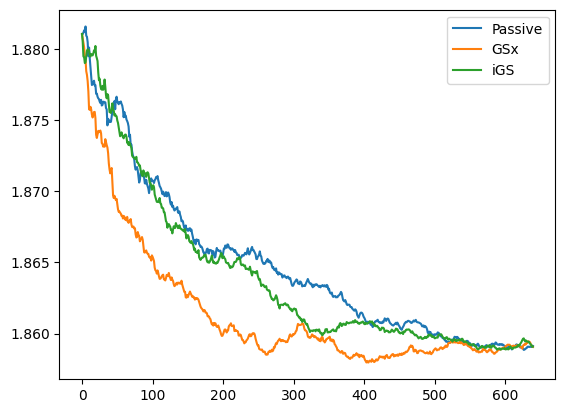

In [17]:
plt.plot(range(0,len(SimulationMean_Passive)), SimulationMean_Passive, label = "Passive")
plt.plot(range(0,len(SimulationMean_GSx)), SimulationMean_GSx, label = "GSx")
# plt.plot(range(0,len(SimulationMean_GSy)), SimulationMean_GSy, label = "GSy")
plt.plot(range(0,len(SimulationMean_iGS)), SimulationMean_iGS, label = "iGS")
plt.legend()
plt.show()

# Issues: 
**selector_args**

Note that
- PassiveLearning takes input df_Candidate
- GSxFunction takes input df1 and df2
- GSyFunction takes input df1 and df2 and Model
- GSxFunction takes input df1 and df2 and Model

In order to make the overall function RunLearningProcedure dynamic, I inserted selector_args for the different variable inputs for the SelectorType.

However, selector_args does not change with each iteration. As such, df_2/df_Candidate in each selector_args remains the same.

Instead, we can change it manually by adding 

        selector_args['df_Candidate'] = df_Candidate                   # NOTE: THIS IS NOT DYNAMIC 
        model_args['df_Train'] = df_Train                              # NOTE: THIS IS NOT DYNAMIC 

However, this is not dynamic as some SelectorType functions do not have df1/df_Train.

The issue with is similar model_args.